**Progetto Fondamenti di analisi dati**

Luigi Priano 1000002081. Professore: Antonino Furnari

Dipartimento: D.M.I Informatica LM-18 A.A. 2023/2024

**Titolo: Analisi Attacchi cardiaci e predizione**

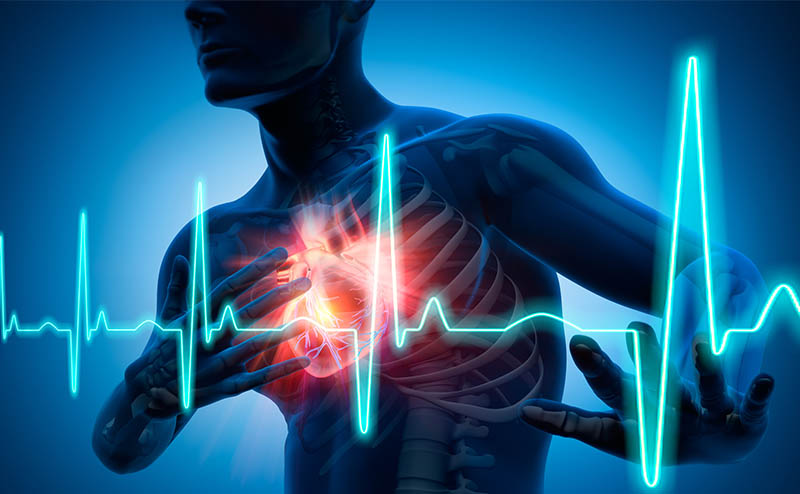

Le malattie cardiovascolari (CVD) sono la prima causa di morte a livello globale e, secondo le stime, mietono 17,9 milioni di vittime ogni anno, ovvero il 31% di tutti i decessi a livello mondiale. Quattro decessi su cinque per malattie cardiovascolari sono dovuti a infarti e ictus e un terzo di questi decessi si verifica prematuramente nelle persone di età inferiore a 70 anni. L'insufficienza cardiaca è un evento comune causato da malattie cardiovascolari e questo set di dati contiene 14 caratteristiche che possono essere utilizzate per prevedere una possibile malattia cardiaca.
Le persone con malattie cardiovascolari o ad alto rischio cardiovascolare necessitano di una diagnosi e di una gestione tempestiva. Un modello di machine learning può essere di grande aiuto per questi tipi di analisi.

**1. Introduzione e comprensione dei dati**

**1.1 Import delle librerie**

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly.express as px
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import torch
from scipy.stats import chi2_contingency
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, r2_score, roc_curve, roc_auc_score
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, RobustScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
import warnings

warnings.filterwarnings("ignore")
pd.set_option("display.max_rows", None)
matplotlib.style.use('ggplot')


**1.2 Import e lettura del dataset**

In [2]:
df=pd.read_csv("/kaggle/input/heart-attack-analysis-prediction-dataset/heart.csv")
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


**1.3 Numero di righe e colonne del data set**

In [3]:
print("Il dataset è formato da (righe, colonne): ", df.shape)

Il dataset è formato da (righe, colonne):  (303, 14)


**1.4 Tipologie di colonne e la loro spiegazione**

In [4]:
df.dtypes

age           int64
sex           int64
cp            int64
trtbps        int64
chol          int64
fbs           int64
restecg       int64
thalachh      int64
exng          int64
oldpeak     float64
slp           int64
caa           int64
thall         int64
output        int64
dtype: object

Tutte le colonne sono di tipo "int64" tranne la colonna oldpeak che si presenta come "float64"

Come è possibile vedere abbiamo diverse colonne e di seguito viene riportato il loro significato:
1. Age: Età del paziente
2. Sex: Sesso del paziente
3. Cp: Tipo di dolore toracico (0 Angina tipico, 1 Angina atipico, 2 Dolore non anginale, 3 Asintomatico)
4. Trtbps: Pressione sanguigna a riposo
5. Chol: Colesterolo
6. Fbs: Glicemia a digiuno > 120 mg/dl (1 Vero, 0 Falso)
7. Restecg: Risultati Ecg a riposo (0 Normale, 1 Onda ST-T normale, 2 Ipertrofia ventricolare sinistra)
8. Thalachh: Frequenza cardiaca massima raggiunta
9. Exng: Esercizi inducono l'angina (1 Vero, 0 Falso)
10. Oldpeak: Depressione ST precedente, il precedente picco di depressione ST registrato
11. Slp: La pendenza dell'onda ST durante il test di sforzo
12. Caa: Il numero di vasi sanguigni principali.
13. Thall: Il risultato del test di stress con tallio, valori tra 0 e 3
14. Output: La variabile target, che rappresenta la presenza o l'assenza di malattia cardiaca

**1.4.1 Verifica valori unici nelle colonne**

In [5]:
dict = {}
for i in list(df.columns):
    dict[i] = df[i].value_counts().shape[0]

pd.DataFrame(dict,index=["unique count"]).transpose()

,unique count
age,41
sex,2
cp,4
trtbps,49
chol,152
fbs,2
restecg,3
thalachh,91
exng,2
oldpeak,40


**1.4.2 Separazione delle variabili continue e categoriche**

In [6]:
cat_cols = ['sex','exng','caa','cp','fbs','restecg','slp','thall']
con_cols = ["age","trtbps","chol","thalachh","oldpeak"]
target_col = ["output"]
print("Colonne categoriche: ", cat_cols)
print("Colonne continue: ", con_cols)
print("Variabile target: ", target_col)

Colonne categoriche:  ['sex', 'exng', 'caa', 'cp', 'fbs', 'restecg', 'slp', 'thall']
Colonne continue:  ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']
Variabile target:  ['output']


**1.4.3 Verifica statistiche dati**

In [7]:
df.describe()


,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


**1.4.4 Verifica presenza di valori null**

In [8]:
df.isnull().sum()


age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64

**1.4.5 Verifica presenza di righe duplicate**

In [9]:
df[df.duplicated()]

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
164,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1


In [10]:
print("Rimozione del duplicato")
df.drop_duplicates(keep='first',inplace=True)
print("Controllo il nuovo numero di righe e colonne")
print("Il dataset è formato da (righe, colonne): ", df.shape)

Rimozione del duplicato
Controllo il nuovo numero di righe e colonne
Il dataset è formato da (righe, colonne):  (302, 14)


**2 Visualizzazione dei dati**

**2.1 Verifica per genere**

Numero di pazienti con sesso pari a 0 sono 96 mentre i pazienti con sesso pari a 1 sono 206


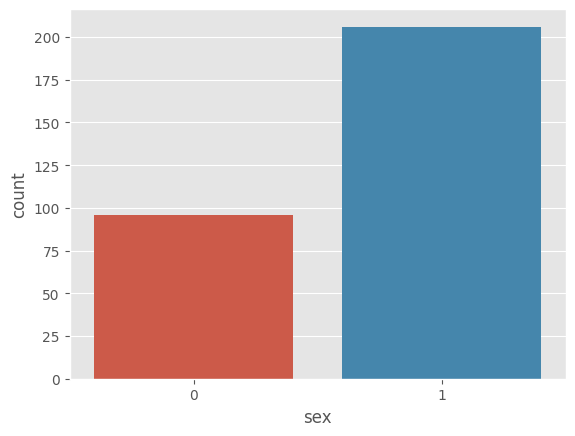

Possiamo vedere che le persone che hanno il sesso pari a 1 sono più del doppio delle persone con sesso 0


In [11]:
x=(df.sex.value_counts())
print(f'Numero di pazienti con sesso pari a 0 sono {x[0]} mentre i pazienti con sesso pari a 1 sono {x[1]}')
p = sns.countplot(data=df, x="sex")
plt.show()
print("Possiamo vedere che le persone che hanno il sesso pari a 1 sono più del doppio delle persone con sesso 0")

**2.1.1 Distribuzione di densità per l'età**

La varianza dell'età è: 81.86575652900926
E' facilmente visibile che la distribuzione d'età è superiore nel range 55-60. Tramite la varianza possiamo calcolare una deviazione standard di circa 9 questo indica che i valori di discostano dalla media in un intervallo -9 | +9 unità dalla media.


<Figure size 1000x1000 with 0 Axes>

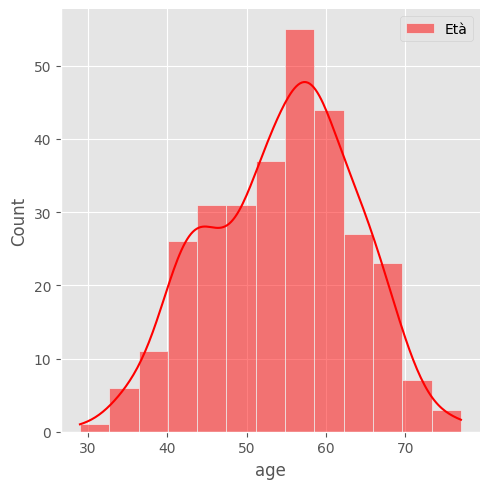

In [12]:
varianza = df['age'].var()
print(f"La varianza dell'età è: {varianza}")
plt.figure(figsize=(10,10))
sns.displot(df.age, color="red", label="Età", kde= True)
plt.legend()
print("E' facilmente visibile che la distribuzione d'età è superiore nel range 55-60. Tramite la varianza possiamo calcolare una deviazione standard di circa 9 questo indica che i valori di discostano dalla media in un intervallo -9 | +9 unità dalla media.")

**2.2 Visualizzazione grafica dei diversi tipi di dolore toracico**

Conteggio valori per tipologia del dolore toracico
cp
0    143
2     86
1     50
3     23
Name: count, dtype: int64


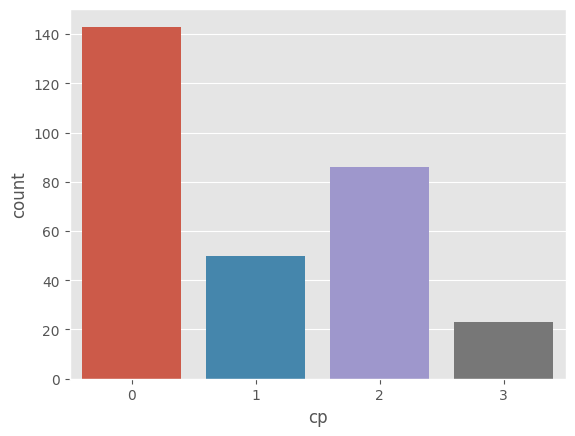

Si può osservare che: 
1. Le persone con l'Angina tipico (0) sono in maggioranza;
2. I casi asintomatici (3) sono i più bassi;
3. Inoltre le persone con l'Angina tipico sono quasi la metà.


In [13]:
x=(df.cp.value_counts())
print("Conteggio valori per tipologia del dolore toracico")
print(x)
p = sns.countplot(data=df, x="cp")
plt.show()
print("Si può osservare che: \n1. Le persone con l'Angina tipico (0) sono in maggioranza;\n2. I casi asintomatici (3) sono i più bassi;\n3. Inoltre le persone con l'Angina tipico sono quasi la metà.")

**2.3 Grafico di pazienti con Glucosio a digiuno > 120 mg/dl**

Conteggio valori per la colonna fbs
fbs
0    257
1     45
Name: count, dtype: int64


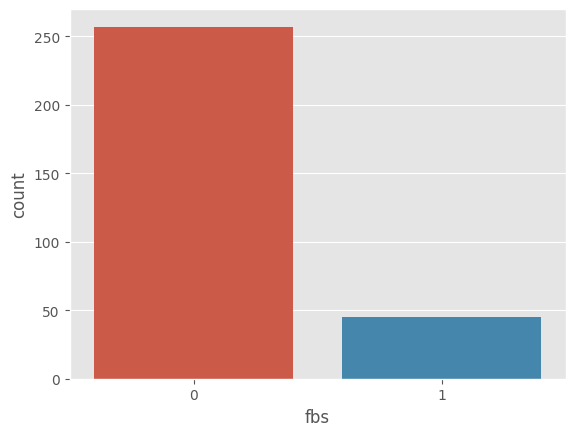

Si può notare che i pazienti con la glicemia a riposo < 120 mg/dl (0) è nettamente superiore ai pazienti che superano la soglia (1)


In [14]:
x=(df.fbs.value_counts())
print("Conteggio valori per la colonna fbs")
print(x)
p = sns.countplot(data=df, x="fbs")
plt.show()
print("Si può notare che i pazienti con la glicemia a riposo < 120 mg/dl (0) è nettamente superiore ai pazienti che superano la soglia (1)")

**2.4 Grafico risultati ECG a riposo**

Conteggio valori per la colonna restecg
restecg
1    151
0    147
2      4
Name: count, dtype: int64


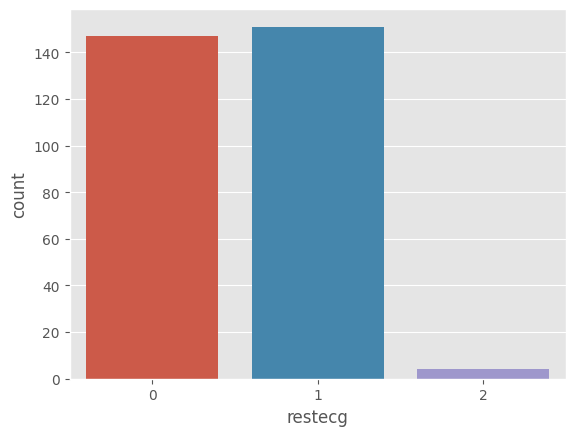

Il conteggio è praticamente lo stesso per i casi (0) e (1), il tipo (2) rispetto ai primi è praticamente trascurabile


In [15]:
x=(df.restecg.value_counts())
print("Conteggio valori per la colonna restecg")
print(x)
p = sns.countplot(data=df, x="restecg")
plt.show()
print("Il conteggio è praticamente lo stesso per i casi (0) e (1), il tipo (2) rispetto ai primi è praticamente trascurabile")

**2.5 Grafico sulla possibilità che l'angina sia provocato da esercizi**

Conteggio valori per la colonna exng
exng
0    203
1     99
Name: count, dtype: int64


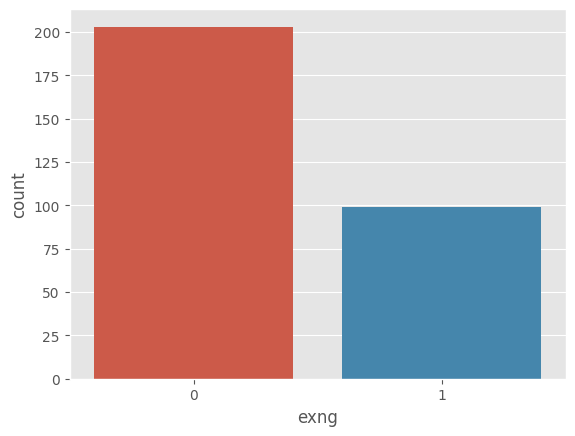

È evidente che il numero di persone che non sperimentano angina indotta dall'esercizio è più del doppio rispetto a coloro che invece la manifestano durante l'attività fisica.


In [16]:
x=(df.exng.value_counts())
print("Conteggio valori per la colonna exng")
print(x)
p = sns.countplot(data=df, x="exng")
plt.show()
print("È evidente che il numero di persone che non sperimentano angina indotta dall'esercizio è più del doppio rispetto a coloro che invece la manifestano durante l'attività fisica.")

**2.6 Verifica Stess test del tallio**

Conteggio valori per la colonna thall
thall
2    165
3    117
1     18
0      2
Name: count, dtype: int64


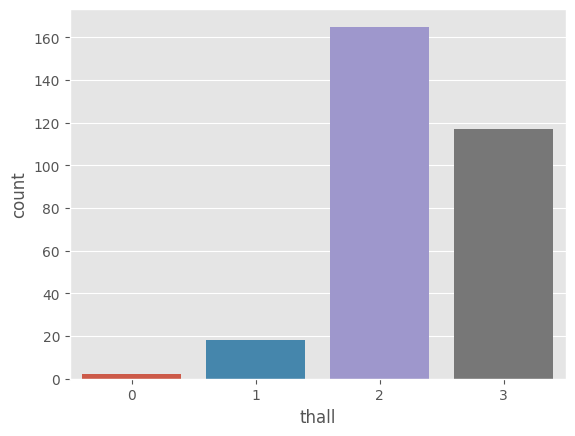

È ben visibile che il tipo (2) è nettamente il maggiore, mentre il tipo (0) è il minore


In [17]:
x=(df.thall.value_counts())
print("Conteggio valori per la colonna thall")
print(x)
p = sns.countplot(data=df, x="thall")
plt.show()
print("È ben visibile che il tipo (2) è nettamente il maggiore, mentre il tipo (0) è il minore")

**2.7 Distribuzione di densità per la pressione sanguigna a riposo**

La varianza della pressione sanguigna a riposo è: 308.4728168797166
La pressione sanguigna ha valori più alti attorno al valore 130. La varianza indica che i dati sono molto dispersi rispetto alla media.


<Figure size 2000x2000 with 0 Axes>

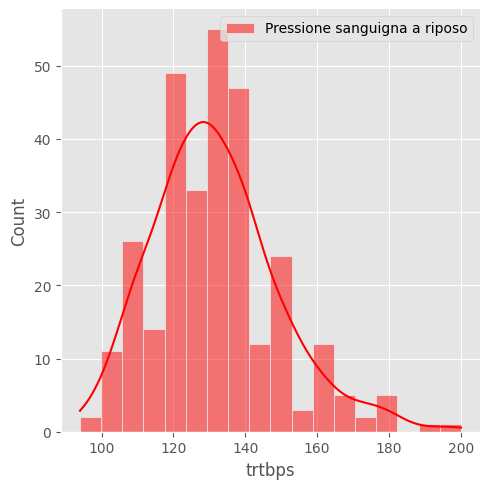

In [18]:
varianza = df['trtbps'].var()
print(f"La varianza della pressione sanguigna a riposo è: {varianza}")
plt.figure(figsize=(20,20))
sns.displot(df.trtbps , color="red", label="Pressione sanguigna a riposo", kde= True)
plt.legend()
print("La pressione sanguigna ha valori più alti attorno al valore 130. La varianza indica che i dati sono molto dispersi rispetto alla media.")

**2.8 Visualizzazione di chi ha contratto la malattia e chi no**

Numero di pazienti che non hanno contratto la malattia sono 138 mentre i pazienti che la hanno contratta sono 164


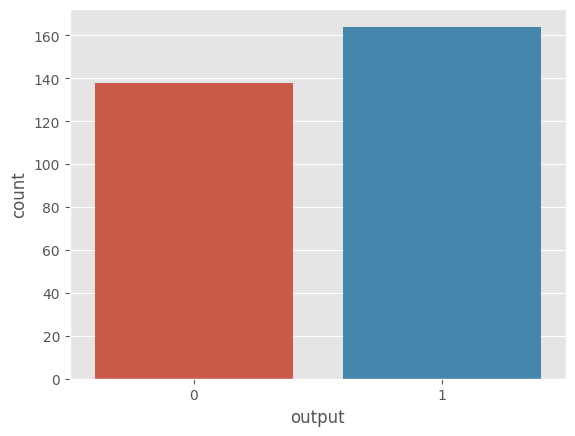

Possiamo vedere che i numeri di chi ha avuto un arresto e chi meno sono abbastanza bilanciati con una differenza di 26 pazienti


In [19]:
x=(df.output.value_counts())
print(f'Numero di pazienti che non hanno contratto la malattia sono {x[0]} mentre i pazienti che la hanno contratta sono {x[1]}')
p = sns.countplot(data=df, x="output")
plt.show()
print("Possiamo vedere che i numeri di chi ha avuto un arresto e chi meno sono abbastanza bilanciati con una differenza di 26 pazienti")

**3 Correlazioni tra variabili**

**3.1 Distribuzione attacchi cardiaci in base al sesso**

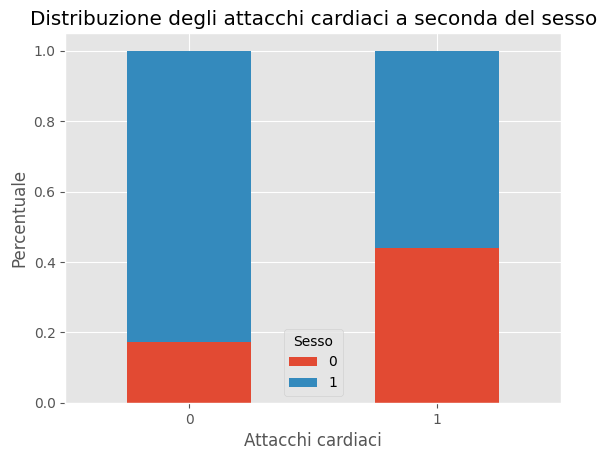

Valore del chi-quadrato: 23.083879459669042
p-value: 1.5508552054949547e-06
Un p-value di queste dimensioni ci porta a rifiturare l'ipotesi nulla che le due variabili siano indipendenti. Ciò suggerisce che c'è un'associazione significativa tra queste due variabili. Essendo che la variabile sex è categorica eseguiamo un coefficiente di Spearman
Coefficiente di correlazione di Spearman: -0.2836093577958625
p-value: 5.402435780432106e-07
Tramite il coefficiente di Spearman possiamo dire che la correlazione è debole, anche qui il p-value rientra nella significatività 0.05 e indica una relazione tra le due variabili.


In [20]:
cross_tab = pd.crosstab(df['output'], df['sex'], normalize='index')

cross_tab.plot.bar(stacked=True)

plt.title("Distribuzione degli attacchi cardiaci a seconda del sesso")
plt.xlabel("Attacchi cardiaci")
plt.ylabel("Percentuale")
plt.xticks(rotation=0)  
plt.legend(title='Sesso')  
plt.show()

contingency_table = pd.crosstab(df['output'], df['sex'])

chi2, p_value, _, _ = chi2_contingency(contingency_table)

print("Valore del chi-quadrato:", chi2)
print("p-value:", p_value)
print("Un p-value di queste dimensioni ci porta a rifiturare l'ipotesi nulla che le due variabili siano indipendenti. Ciò suggerisce che c'è un'associazione significativa tra queste due variabili. Essendo che la variabile sex è categorica eseguiamo un coefficiente di Spearman")

spearman_corr, spearman_p_value = stats.spearmanr(df['output'], df['sex'])

print("Coefficiente di correlazione di Spearman:", spearman_corr)
print("p-value:", spearman_p_value)
print("Tramite il coefficiente di Spearman possiamo dire che la correlazione è debole, anche qui il p-value rientra nella significatività 0.05 e indica una relazione tra le due variabili.")

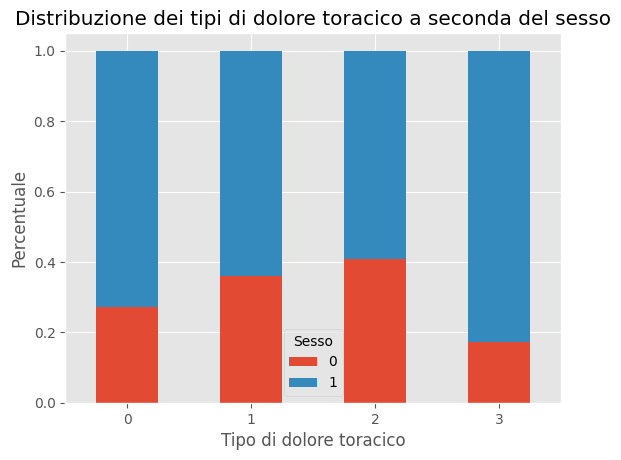

Valore del chi-quadrato: 7.1006186360498
p-value: 0.06875893200193163
Usando un livello di significatività pari a 0.05, possiamo vedere che il p-value > 0.05 quindi, questo significa che non ci sono prove sufficienti per rifiutare l'ipotesi nulla di indipendenza tra il tipo di dolore toracico e il sesso del paziente.
Coefficiente di correlazione di Spearman: -0.0647389985101073
p-value: 0.26205159797037547
Il coefficiente di Spearman conferma che non esiste una relazione tra le due variabili, lo stesso lo si osserva tramite il p-value

Dal grafico è possibile notare una particolarità. L'angina tipico è presente principalmente nel sesso (0) con più del doppio dei casi, questo è dovuto alla imparità di casi nel dataset, riguardando il grafico dei sessi l'elemento (1) è pari a 206 pazienti contro i 96 dell'elemento (0)


In [21]:
cross_tab = pd.crosstab(df['cp'], df['sex'], normalize='index')

cross_tab.plot.bar(stacked=True)

plt.title("Distribuzione dei tipi di dolore toracico a seconda del sesso")
plt.xlabel("Tipo di dolore toracico")
plt.ylabel("Percentuale")
plt.xticks(rotation=0)  
plt.legend(title='Sesso')  
plt.show()

contingency_table = pd.crosstab(df['cp'], df['sex'])

chi2, p_value, _, _ = chi2_contingency(contingency_table)

print("Valore del chi-quadrato:", chi2)
print("p-value:", p_value)
print("Usando un livello di significatività pari a 0.05, possiamo vedere che il p-value > 0.05 quindi, questo significa che non ci sono prove sufficienti per rifiutare l'ipotesi nulla di indipendenza tra il tipo di dolore toracico e il sesso del paziente.")
spearman_corr, spearman_p_value = stats.spearmanr(df['cp'], df['sex'])

print("Coefficiente di correlazione di Spearman:", spearman_corr)
print("p-value:", spearman_p_value)
print("Il coefficiente di Spearman conferma che non esiste una relazione tra le due variabili, lo stesso lo si osserva tramite il p-value")
print()
print("Dal grafico è possibile notare una particolarità. L'angina tipico è presente principalmente nel sesso (0) con più del doppio dei casi, questo è dovuto alla imparità di casi nel dataset, riguardando il grafico dei sessi l'elemento (1) è pari a 206 pazienti contro i 96 dell'elemento (0)")

**3.3 L'età è correlata con l'attacco cardiaco?**


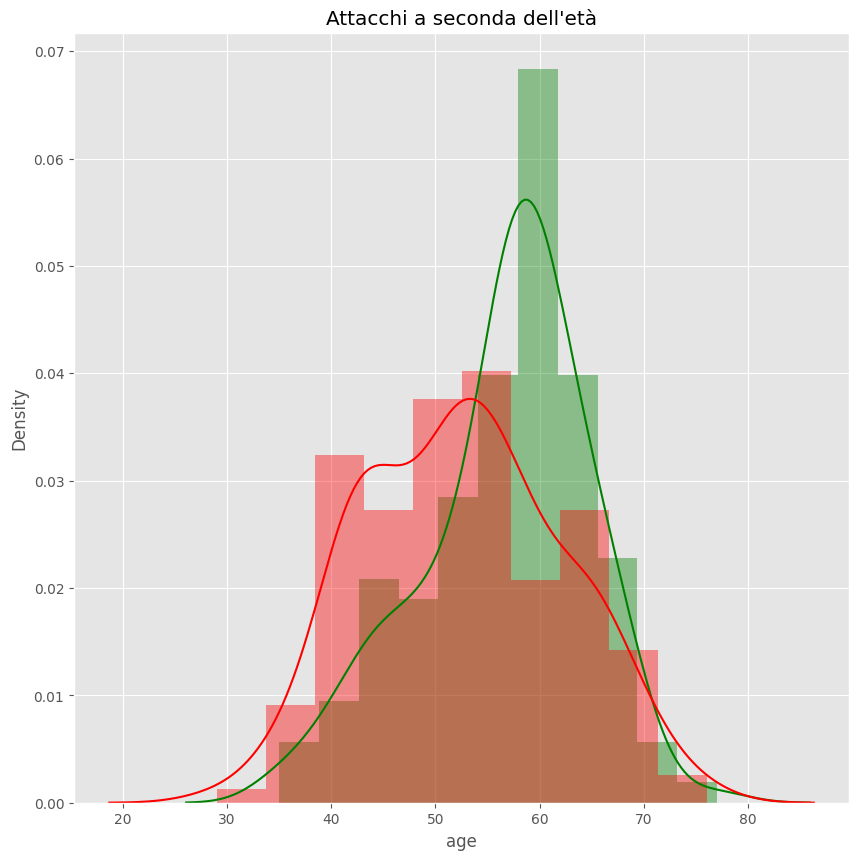

Coefficiente di correlazione di Spearman: -0.2348452903988662
p-value: 3.755240402707282e-05
Il coefficiente di Spearman indica una correlazione debole tra le variabili, in questo caso il p-value è sotto il limite di soglia e indica la presenza di una relazione

La presenza di attacchi cardiaci è più presente nell'intervallo d'età compreso tra i 50 e i 55 anni


In [22]:
plt.figure(figsize=(10,10))
sns.distplot(df[df['output'] == 0]["age"], color='green',kde=True,) 
sns.distplot(df[df['output'] == 1]["age"], color='red',kde=True)
plt.title('Attacchi a seconda dell\'età')
plt.show()

spearman_corr, spearman_p_value = stats.spearmanr(df['output'], df['age'])

print("Coefficiente di correlazione di Spearman:", spearman_corr)
print("p-value:", spearman_p_value)
print("Il coefficiente di Spearman indica una correlazione debole tra le variabili, in questo caso il p-value è sotto il limite di soglia e indica la presenza di una relazione")
print()
print("La presenza di attacchi cardiaci è più presente nell'intervallo d'età compreso tra i 50 e i 55 anni")

In [23]:
fig = px.box(df,y="age",x="output",title=f"BoxPlot degli attacchi cardiaci causati dall'età")
fig.show()

**3.4 Il colesterolo è correlato con l'attacco cardiaco?**

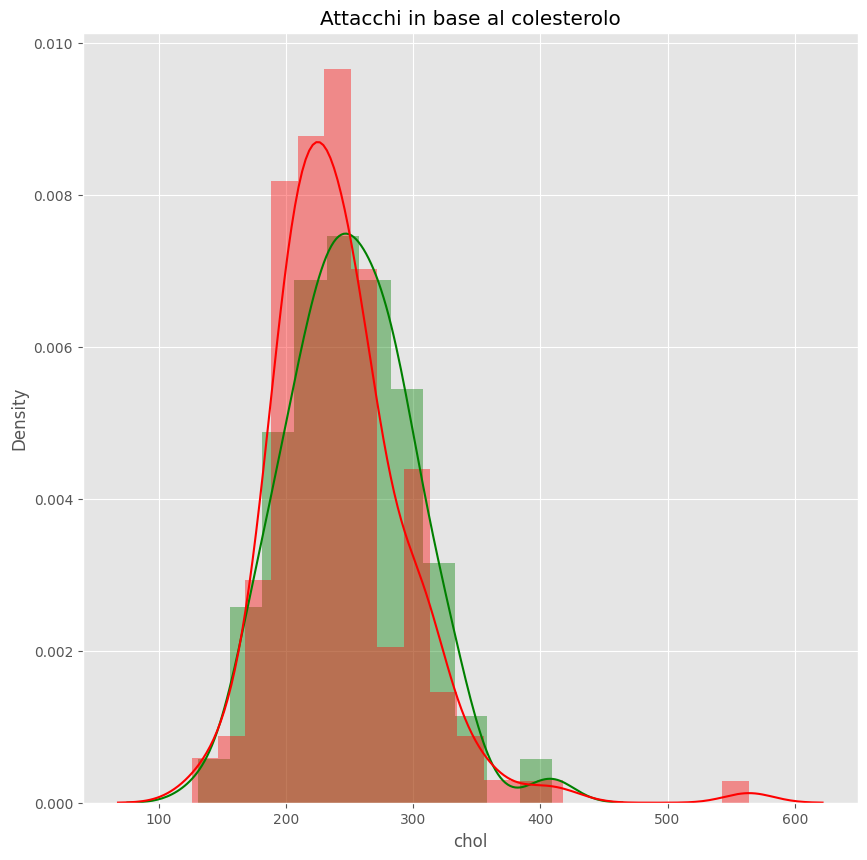

Coefficiente di correlazione di Spearman: -0.11700648571015242
p-value: 0.042162967552230965
In questo caso Spearman indica una relazione negativa molto debole, questa è confermata dal p-value < 0.05

Dal grafico, è evidente un picco significativo di attacchi cardiaci nell'intervallo di colesterolo compreso tra 200 e 250.


In [24]:
plt.figure(figsize=(10,10))
sns.distplot(df[df['output'] == 0]["chol"], color='green',kde=True,) 
sns.distplot(df[df['output'] == 1]["chol"], color='red',kde=True)
plt.title('Attacchi in base al colesterolo')
plt.show()

spearman_corr, spearman_p_value = stats.spearmanr(df['output'], df['chol'])

print("Coefficiente di correlazione di Spearman:", spearman_corr)
print("p-value:", spearman_p_value)
print("In questo caso Spearman indica una relazione negativa molto debole, questa è confermata dal p-value < 0.05")
print()
print("Dal grafico, è evidente un picco significativo di attacchi cardiaci nell'intervallo di colesterolo compreso tra 200 e 250.")

In [25]:
fig = px.box(df,y="chol",x="output",title=f"BoxPlot degli attacchi cardiaci causati dal colesterolo")
fig.show()

**3.5 La pressione sanguigna comporta attacchi cardiaci?**

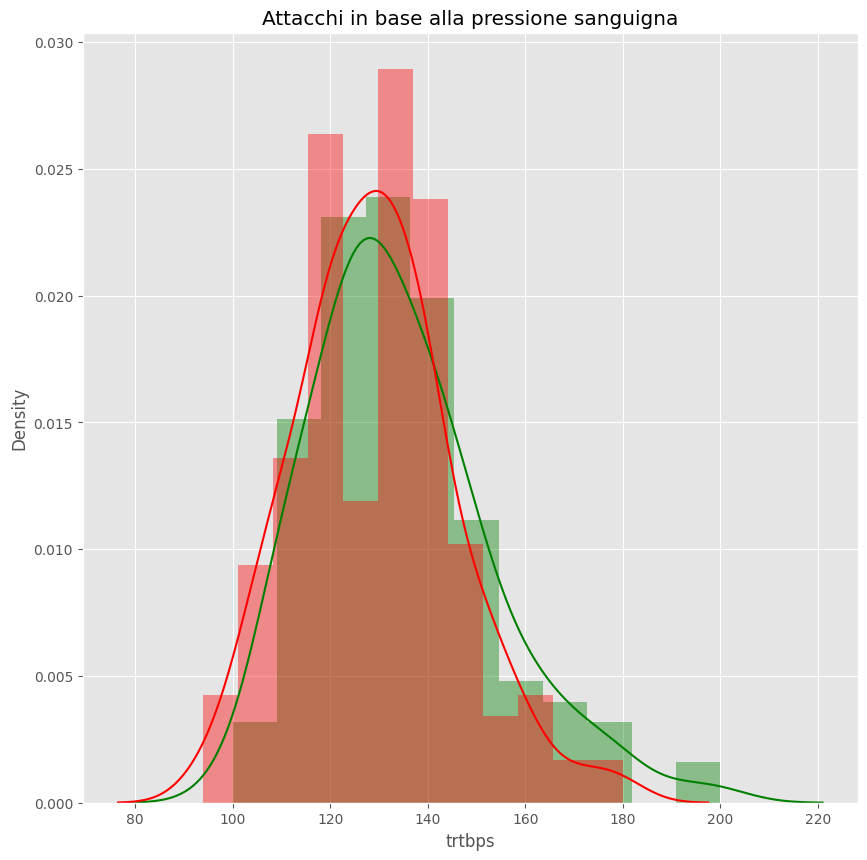

Coefficiente di correlazione di Spearman: -0.12347766243476913
p-value: 0.03194246651172851
Il coefficiente di correlazione di Spearman indica una relazione debole, questa è confermata dal p-value

Nel grafico sono chiaramente identificabili due picchi di attacchi cardiaci in relazione alla pressione sanguigna. Il primo picco è evidente in un intervallo di pressione compreso tra 115 e 125, mentre il secondo picco, di dimensioni superiori al primo, si osserva tra 130 e 140.


In [26]:
plt.figure(figsize=(10,10))
sns.distplot(df[df['output'] == 0]["trtbps"], color='green',kde=True,) 
sns.distplot(df[df['output'] == 1]["trtbps"], color='red',kde=True)
plt.title('Attacchi in base alla pressione sanguigna')
plt.show()

spearman_corr, spearman_p_value = stats.spearmanr(df['output'], df['trtbps'])

print("Coefficiente di correlazione di Spearman:", spearman_corr)
print("p-value:", spearman_p_value)
print("Il coefficiente di correlazione di Spearman indica una relazione debole, questa è confermata dal p-value")
print()
print("Nel grafico sono chiaramente identificabili due picchi di attacchi cardiaci in relazione alla pressione sanguigna. Il primo picco è evidente in un intervallo di pressione compreso tra 115 e 125, mentre il secondo picco, di dimensioni superiori al primo, si osserva tra 130 e 140.")

In [27]:
fig = px.box(df,y="trtbps",x="output",title=f"BoxPlot degli attacchi cardiaci causati dalla pressione sanguigna")
fig.show()

**3.5.1 La pressione sanguigna alta è correlata al colesterolo?**

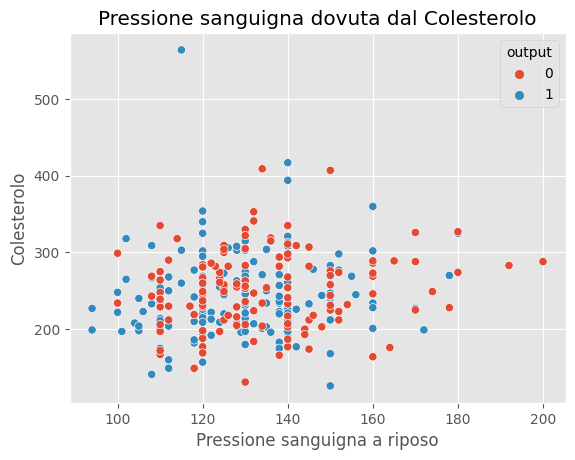

Coefficiente di correlazione di Spearman: 0.13021022519032877
p-value: 0.02363127598285528
La pressione sanguigna è correlata al colesterolo avendo il p-value minore di 0.05, la correlazione però è debole
            trtbps         chol
trtbps  308.472817   113.853821
chol    113.853821  2678.423588
Dal calcolo della covarianza vediamo il valore della relazione delle due variabili ovvero 113.85 indica che persone con pressione sanguigna a riposo più alta tendono ad avere anche livelli più alti di colesterolo, secondo questo dataset.


In [28]:
sns.scatterplot(x='trtbps', y='chol', hue='output', data=df)
plt.title('Pressione sanguigna dovuta dal Colesterolo')
plt.xlabel('Pressione sanguigna a riposo')
plt.ylabel('Colesterolo')
plt.show()

spearman_corr, spearman_p_value = stats.spearmanr(df['trtbps'], df['chol'])

print("Coefficiente di correlazione di Spearman:", spearman_corr)
print("p-value:", spearman_p_value)

print("La pressione sanguigna è correlata al colesterolo avendo il p-value minore di 0.05, la correlazione però è debole")

covarianza = df[['trtbps', 'chol']].cov()
print(covarianza)
print("Dal calcolo della covarianza vediamo il valore della relazione delle due variabili ovvero 113.85 indica che persone con pressione sanguigna a riposo più alta tendono ad avere anche livelli più alti di colesterolo, secondo questo dataset.")

**3.6 Frequenza massima battito cardiaco raggiunta in relazione con l'attacco cardiaco**

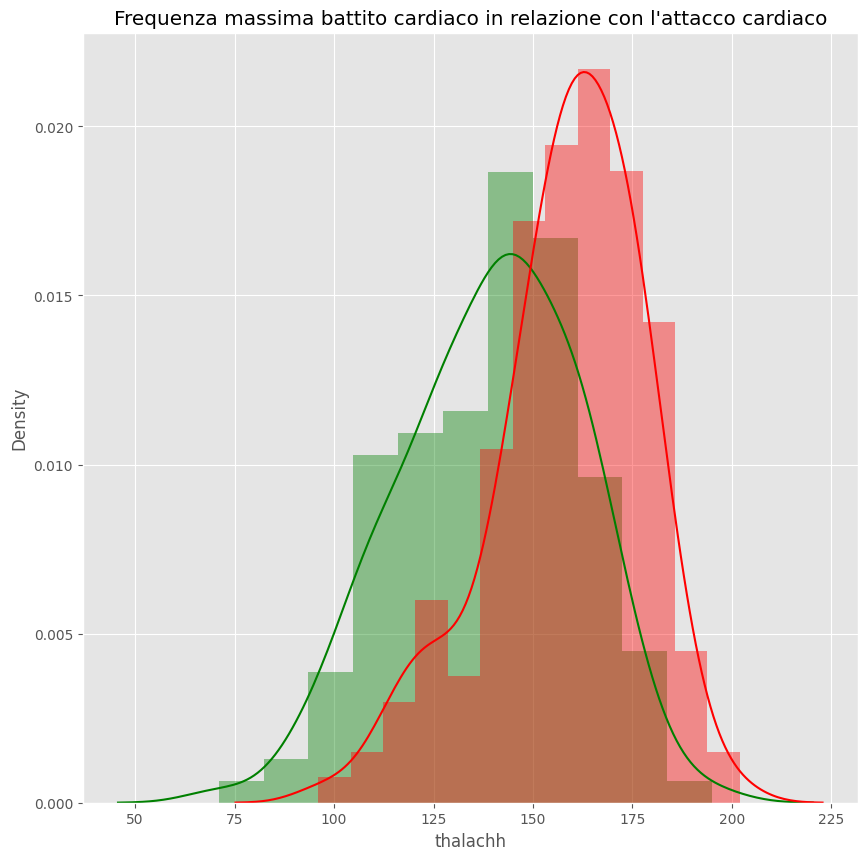

Coefficiente di correlazione di Spearman: 0.4263679771389331
p-value: 9.051678417240114e-15
Il p-value è molto basso quindi esiste una relazione tra gli attacchi cardiaci e la frequenza massima del battito cardiaco, inoltre tramite il coefficiente di Spearman possiamo notare che la correlazione è moderata.

Nel grafico, si osserva un picco di casi di attacchi cardiaci nell'intervallo compreso tra 150 e 180, mentre per valori al di sotto di 150 si evidenzia un picco di pazienti non affetti dall'attacco cardiaco.


In [29]:
plt.figure(figsize=(10,10))
sns.distplot(df[df['output'] == 0]["thalachh"], color='green',kde=True,) 
sns.distplot(df[df['output'] == 1]["thalachh"], color='red',kde=True)
plt.title('Frequenza massima battito cardiaco in relazione con l\'attacco cardiaco')
plt.show()

spearman_corr, spearman_p_value = stats.spearmanr(df['output'], df['thalachh'])

print("Coefficiente di correlazione di Spearman:", spearman_corr)
print("p-value:", spearman_p_value)
print("Il p-value è molto basso quindi esiste una relazione tra gli attacchi cardiaci e la frequenza massima del battito cardiaco, inoltre tramite il coefficiente di Spearman possiamo notare che la correlazione è moderata.")
print()
print("Nel grafico, si osserva un picco di casi di attacchi cardiaci nell'intervallo compreso tra 150 e 180, mentre per valori al di sotto di 150 si evidenzia un picco di pazienti non affetti dall'attacco cardiaco.")

In [30]:
fig = px.box(df,y="thalachh",x="output",title=f"BoxPlot degli attacchi cardiaci causati dalla frequenza massima cardiaca")
fig.show()

**3.7 Pairplot basato sulla variabile target**

<Figure size 2000x2000 with 0 Axes>

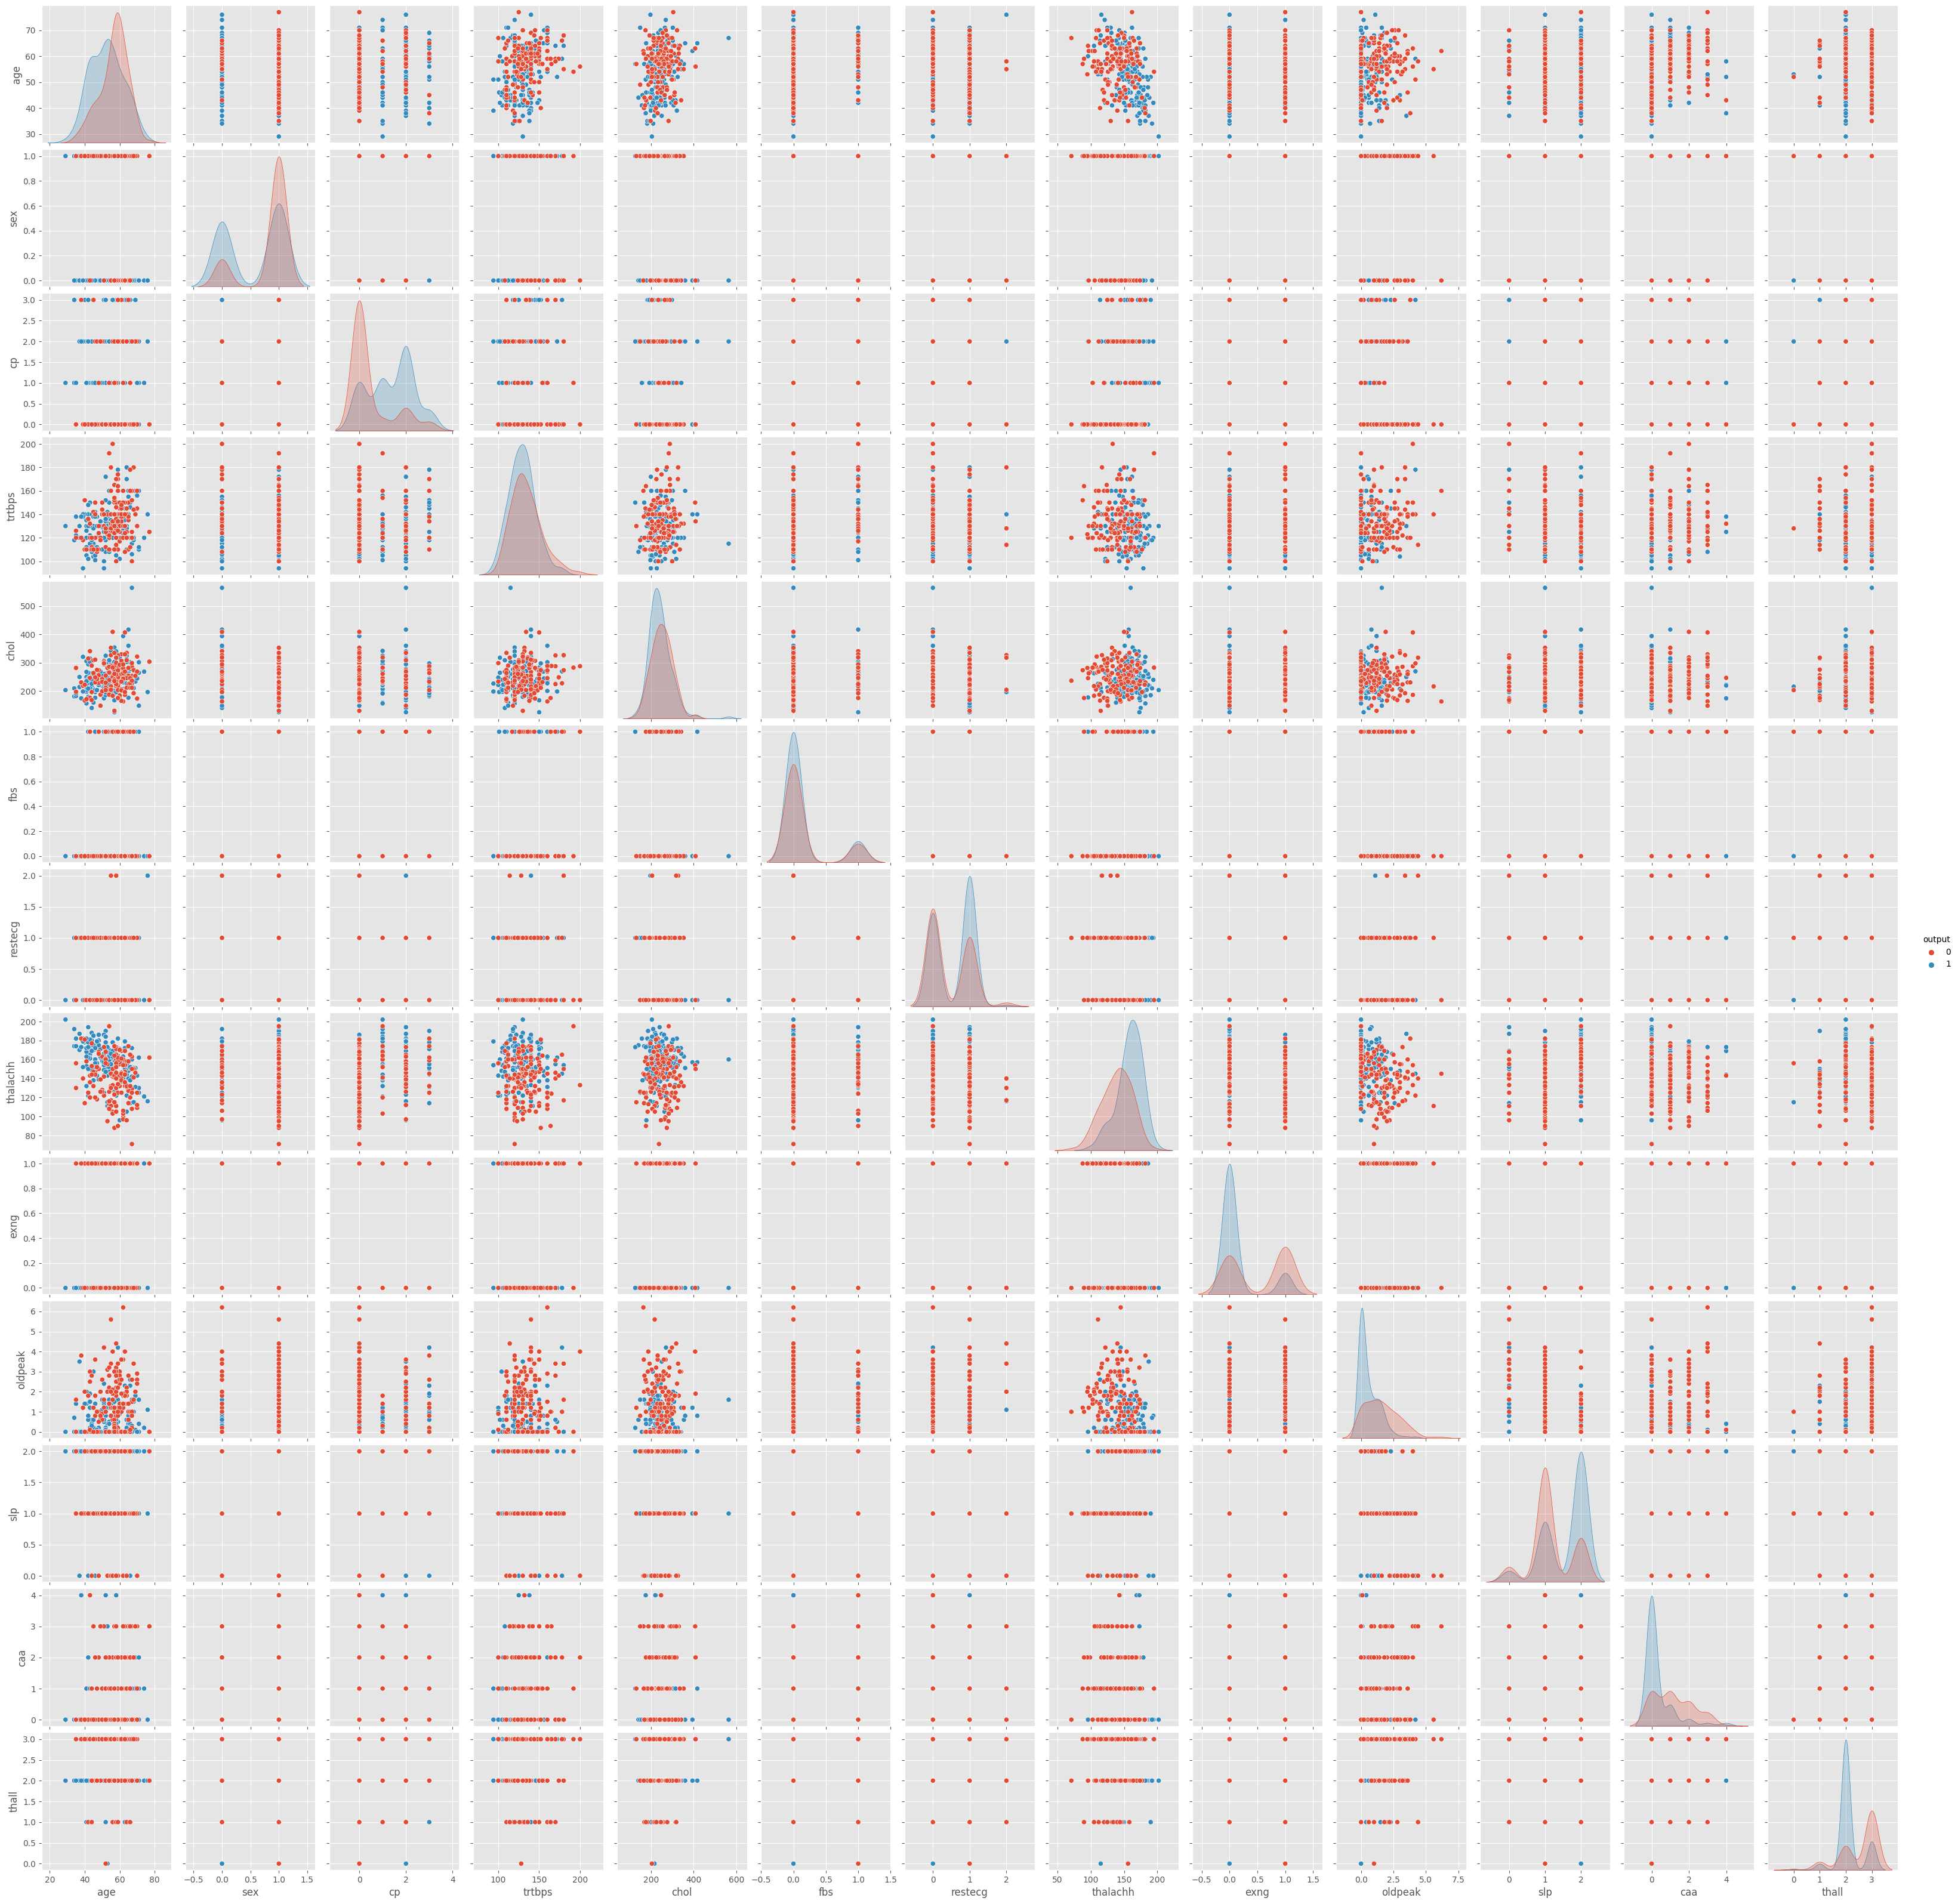

In [31]:
plt.figure(figsize=(20, 20))
sns.pairplot(df, hue="output")
plt.show()

**3.8 Matrice di correlazione**

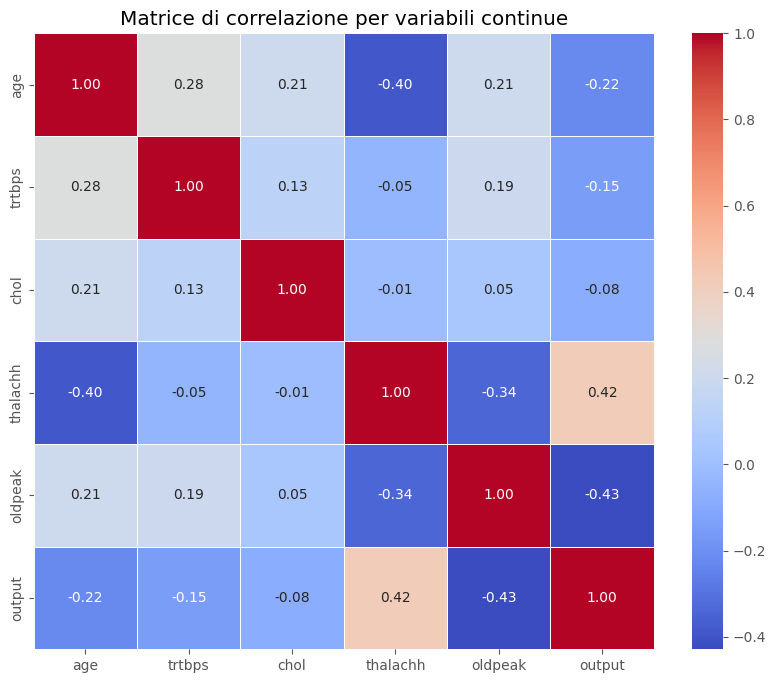

Una piccola analisi su questa matrice la possiamo vedere analizzando la variabile target output, questa ha una correlazione moderata con la frequenza cardiaca massima raggiunta e una correlazione simile ma negativa con la variabile oldpeak. Un'altra coppia di variabili correlate tra di loro sono l'età con la frequenza massima del battito cardiaco come visto già durante l'analisi.


In [32]:
continuous_columns = ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak', 'output']

df_continuous = df[continuous_columns]

correlation_matrix_continuous = df_continuous.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_continuous, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title("Matrice di correlazione per variabili continue")
plt.show()
print("Una piccola analisi su questa matrice la possiamo vedere analizzando la variabile target output, questa ha una correlazione moderata con la frequenza cardiaca massima raggiunta e una correlazione simile ma negativa con la variabile oldpeak. Un'altra coppia di variabili correlate tra di loro sono l'età con la frequenza massima del battito cardiaco come visto già durante l'analisi.")

**3.9 Regressione logistica**

In [33]:
X = df[['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh', 'exng', 'oldpeak', 'slp', 'caa', 'thall']]
y = df['output']

# Aggiungere una costante al set di features
X = sm.add_constant(X)

# Creare e addestrare il modello di regressione logistica
model = sm.Logit(y, X)
result = model.fit()

# Stampare un riepilogo dei risultati, inclusi i p-value
print(result.summary())

print("Da questi risultati possiamo dedurre che, usando un vincolo di significatività pari a 0.05, possiamo osservare le correlazioni della variabile 'output' con le seguenti variabili sex, cp, thalachh, exng, oldpeak, caa e thall.")

Optimization terminated successfully.
         Current function value: 0.348265
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 output   No. Observations:                  302
Model:                          Logit   Df Residuals:                      288
Method:                           MLE   Df Model:                           13
Date:                Thu, 22 Feb 2024   Pseudo R-squ.:                  0.4949
Time:                        08:53:33   Log-Likelihood:                -105.18
converged:                       True   LL-Null:                       -208.21
Covariance Type:            nonrobust   LLR p-value:                 7.740e-37
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.3042      2.578      1.282      0.200      -1.748       8.357
age           -0.0015      0.

**4 Predizione del rischio di un attacco cardiaco**

In [34]:
# print("Il codice inizialmente crea una copia del DataFrame originale per preservarne l'integrità, successivamente estrae tutte le colonne ad eccezione dell'ultima, assegnandole alla variabile x1 come insieme delle variabili indipendenti (feature). L'ultima colonna, rappresentante la variabile dipendente (target), viene invece assegnata a y1. Segue la divisione del dataset in set di addestramento e di test mediante la funzione train_test_split, dove il 20% del dataset è riservato al test, garantendo la riproducibilità dei risultati attraverso l'uso del parametro random_state. Infine, si procede con la standardizzazione delle feature di x1 (tramite rimozione della media e scala alla varianza unitaria) utilizzando StandardScaler, un passaggio cruciale per l'ottimizzazione delle performance del modello di machine learning. Tale standardizzazione non viene applicata a y1, poiché si assume che contenga solo valori binari (0 e 1), i quali non necessitano di tale processo.")

df1 = df
x1 = df1.iloc[:, 1:-1].values
y1 = df1.iloc[:, -1].values
x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, test_size= 0.2, random_state= 0)
scaler = StandardScaler()
x1_train = scaler.fit_transform(x1_train)
x1_test = scaler.transform(x1_test)

print("La forma di x1_train è      ", x1_train.shape)
print("La forma di x1_test è       ",x1_test.shape)
print("La forma di y1_train è      ",y1_train.shape)
print("La forma di y1_test è       ",y1_test.shape)

La forma di x1_train è       (241, 12)
La forma di x1_test è        (61, 12)
La forma di y1_train è       (241,)
La forma di y1_test è        (61,)


**4.1 Classificatori Lineari**

**4.1.1 Score SVM**

In [35]:
# print("Il codice inizia istanziando un classificatore SVM lineare. Successivamente, addestra questo classificatore utilizzando le features x1_train e i valori target corrispondenti y1_train. Successivamente, utilizza il set di test x1_test per fare previsioni utilizzando il classificatore SVM addestrato. Infine, calcola lo score del classificatore SVM utilizzando le previsioni fatte sul set di test e confrontandole con i valori target reali.")
clf = SVC(kernel='linear', C=1, random_state=0).fit(x1_train,y1_train)
y_pred = clf.predict(x1_test)
print("L'accuratezza del punteggio SVM è: ", accuracy_score(y1_test, y_pred)*100, "%")

L'accuratezza del punteggio SVM è:  86.88524590163934 %


**4.1.2 Ottimizzazione iperparametri per lo score SVM**

I migliori parametri sono:  {'C': 2, 'gamma': 0.05}
Il punteggio migliore è:  83.01870748299321 %
Il test di accuratezza dello score SVM dopo aver modificato gli iperparametri è:  90.1639344262295 %


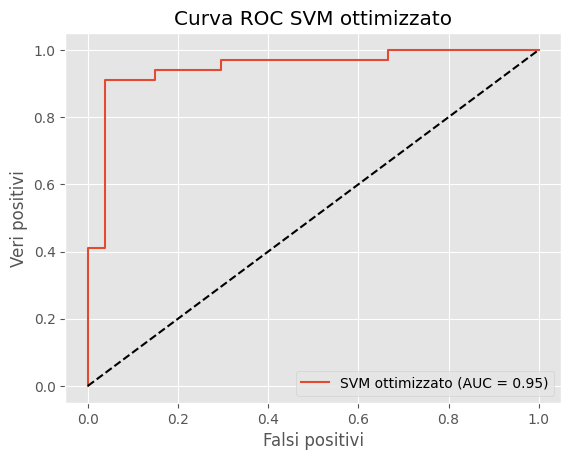

In [36]:
# print("Per prima cosa definiamo un classificatore SVM senza specificare i parametri, definiamo un'insieme di valori C e gamma da testare. Iterativamente cerchiamo i migliori iperparametri che massimizzano il punteggio. Di seguito abbiamo la stampa dei migliori iperparametri e dei punteggi ottenuti con essi.")
svm = SVC(probability=True)
parameters = {"C":np.arange(1,10,1),'gamma':[0.00001,0.00005, 0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1,5]}
searcher = GridSearchCV(svm, parameters)
searcher.fit(x1_train, y1_train)
print("I migliori parametri sono: ", searcher.best_params_)
print("Il punteggio migliore è: ", (searcher.best_score_)*100, "%")
y_pred = searcher.predict(x1_test)
print("Il test di accuratezza dello score SVM dopo aver modificato gli iperparametri è: ", accuracy_score(y1_test, y_pred)*100, "%")
y_pred_prob = searcher.predict_proba(x1_test)[:, 1]

# Calcolo di FPR, TPR, e soglie per la curva ROC
fpr, tpr, thresholds = roc_curve(y1_test, y_pred_prob)

# Calcolo dell'area sotto la curva ROC (AUC)
roc_auc = roc_auc_score(y1_test, y_pred_prob)

# Creazione del grafico della curva ROC
plt.plot(fpr, tpr, label='SVM ottimizzato (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Disegna una linea tratteggiata come riferimento
plt.xlabel('Falsi positivi')  # Etichetta asse x
plt.ylabel('Veri positivi')  # Etichetta asse y
plt.title('Curva ROC SVM ottimizzato')  # Titolo del grafico
plt.legend(loc="best")  # Aggiunta della legenda nel miglior posizionamento
plt.show()

**4.1.3 Regressione logistica**

Il test di accuratezza della Regressione lineare è:  88.52459016393442 %
Per calcolare la curva ROC usiamo un modello di regressione logistica addestrato per ottenere le probabilità predette per la classe positiva, calcolando successivamente i falsi positivi e i veri positivi.


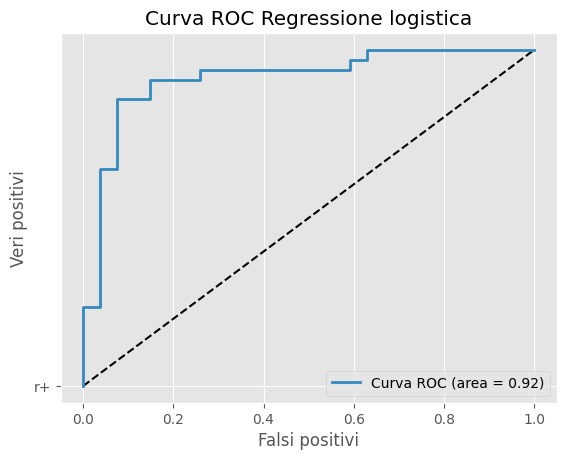

In [37]:
# print("Il codice istanzia un modello di regressione logistica senza specificare alcun iperparametro. Successivamente, addestra il modello utilizzando il set di addestramento x1_train e y1_train. Successivamente, utilizza il modello addestrato per ottenere le previsioni di probabilità per ciascuna classe sul set di test x1_test. Per ciascuna osservazione nel set di test, viene selezionata la classe con la probabilità più alta. Infine, lo score di accuratezza viene calcolato confrontando le previsioni con i valori target veri y1_test e stampato.")
logreg = LogisticRegression()
logreg.fit(x1_train, y1_train)
y_pred_prob = logreg.predict_proba(x1_test)
y_pred = np.argmax(y_pred_prob,axis=1)
print("Il test di accuratezza della Regressione lineare è: ", accuracy_score(y1_test, y_pred)*100, "%")
print("Per calcolare la curva ROC usiamo un modello di regressione logistica addestrato per ottenere le probabilità predette per la classe positiva, calcolando successivamente i falsi positivi e i veri positivi.")
y_pred_prob = logreg.predict_proba(x1_test)[:,1]
fpr,tpr,threshols=roc_curve(y1_test,y_pred_prob)
roc_auc = roc_auc_score(y1_test, y_pred_prob)
plt.plot([0,1],[0,1],"k--",'r+')
plt.plot(fpr, tpr, lw=2, label='Curva ROC (area = %0.2f)' % roc_auc)
plt.xlabel("Falsi positivi")
plt.ylabel("Veri positivi")
plt.legend(loc="lower right")
plt.title("Curva ROC Regressione logistica")
plt.show()

**5 Classificatori basati su probabilità e vicinanza**

**5.1 1-NN**

In [38]:
model = KNeighborsClassifier(n_neighbors = 1)  
model.fit(x1_train, y1_train)
predicted = model.predict(x1_test)
print(confusion_matrix(y1_test, predicted))
print("L'accuratezza di 1-NN è: ", accuracy_score(y1_test, predicted.round())*100, "%")

[[23  4]
 [ 6 28]]
L'accuratezza di 1-NN è:  83.60655737704919 %


**5.2 K-NN Ottimizzato**

Iteriamo KNN per tutti e 40 i valori per verificare quale ha l'errore più basso


Text(0, 0.5, 'Tasso di errore')

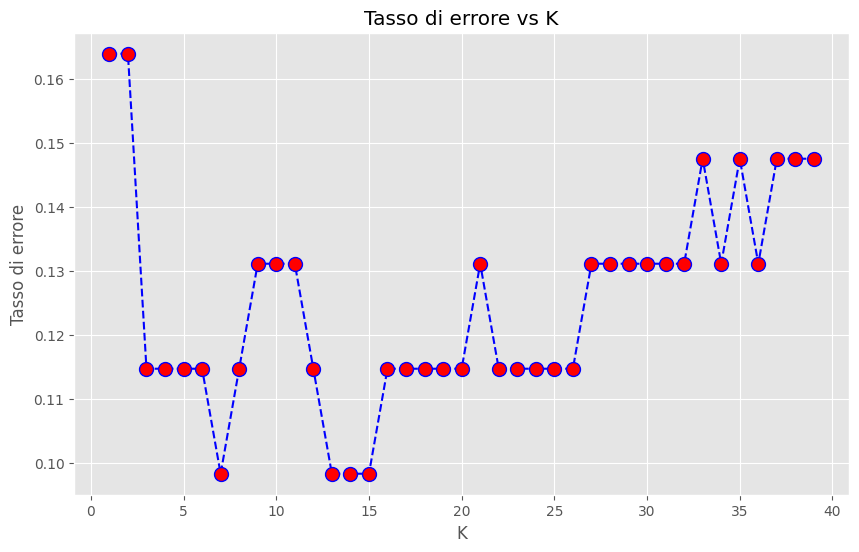

In [39]:
print("Iteriamo KNN per tutti e 40 i valori per verificare quale ha l'errore più basso")
error_rate = []
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x1_train, y1_train)
    pred_i = knn.predict(x1_test)
    error_rate.append(np.mean(pred_i != y1_test)) 
plt.figure(figsize=[10,6])
plt.plot(range(1,40), error_rate, color='blue', linestyle='dashed',
         marker='o', markerfacecolor='red', markersize=10)
plt.title('Tasso di errore vs K')
plt.xlabel('K')
plt.ylabel('Tasso di errore')

Verifichiamo l'accuratezza di K-NN ottimizzato all'iperparametro 7

[[25  2]
 [ 4 30]]
L'accuratezza di K-NN (Iperparametro 7):  90.1639344262295 %


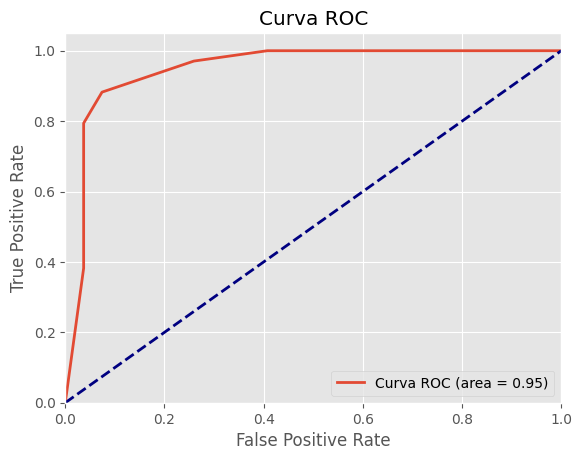

In [40]:
model = KNeighborsClassifier(n_neighbors = 7)
model.fit(x1_train, y1_train)
predicted = model.predict(x1_test)
print(confusion_matrix(y1_test, predicted))
print("L'accuratezza di K-NN (Iperparametro 7): ", accuracy_score(y1_test, predicted.round())*100, "%")
y1_scores = model.predict_proba(x1_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y1_test, y1_scores)
roc_auc = roc_auc_score(y1_test, y1_scores)

plt.figure()
plt.plot(fpr, tpr, lw=2, label='Curva ROC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

**5.4 Naive Bayes Gaussiano**

In [41]:
model = GaussianNB()
model.fit(x1_train, y1_train)
predicted = model.predict(x1_test)
print("L'accuratezza usando il modello Gaussiano di Naive Bayes è: ", accuracy_score(y1_test, predicted)*100, "%")

L'accuratezza usando il modello Gaussiano di Naive Bayes è:  88.52459016393442 %


**Conclusioni**

L'analisi delle accuratezze ottenute dai diversi modelli di machine learning applicati al dataset sugli attacchi cardiaci fornisce risultati significativi riguardo alla loro efficacia nella previsione di eventuali attacchi cardiaci. La variazione delle performance tra i modelli evidenzia l'importanza della scelta del giusto algoritmo e della configurazione degli iperparametri in base alla natura specifica dei dati trattati.
In particolare, il modello K-Nearest Neighbors (K-NN) con un iperparametro impostato a 7 e il Support Vector Machine (SVM) ottimizzato attraverso la modifica degli iperparametri emergono come i più precisi, entrambi con un'accuratezza di circa il 90.16%. Questo suggerisce che per il dataset in uso, le metodologie sopra menzionate riescono ad identificare in modo molto efficace i casi di attacchi cardiaci, inoltre entrambi i metodi presentano la stessa area AUC quindi l'utilizzo di entrambi risulta robusto. D'altra parte, l'1-Nearest Neighbor (1-NN), pur essendo un modello molto semplice che considera il vicino più prossimo per la classificazione, mostra l'accuratezza più bassa, circa l'83.61%, questo potrebbe indicare che un approccio semplice non è adeguato per gestire la complessità del dataset. Sia il modello Gaussiano che quello di Bernoulli del Naive Bayes forniscono risultati intermedi, con accuratezze dell'88.52% e dell'86.89% rispettivamente. Questo dimostra che, nonostante la loro assunzione di indipendenza tra le feature possa non essere completamente realistica in contesti medici complessi, riescono comunque a fornire stime ragionevolmente accurate. In conclusione, l'analisi delle prestazioni di vari modelli di machine learning sul dataset di attacchi cardiaci sottolinea l'importanza di una selezione accurata del modello e della configurazione degli iperparametri. Modelli come K-NN e SVM, quando correttamente ottimizzati, sembrano offrire le migliori prestazioni, riflettendo la complessità e la natura specifica dei dati medici. Questi risultati possono guidare la scelta di strategie di modellazione in studi futuri, con l'obiettivo di migliorare la previsione e, di conseguenza, la prevenzione degli attacchi cardiaci.